### Import the necessary packages.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

### Import train and test dataset

In [93]:
train=pd.read_csv("/content/gdrive/MyDrive/Data Sprint 52 - COVID-19 SARS B-cell Epitope Prediction/training_data.csv")
test=pd.read_csv("/content/gdrive/MyDrive/Data Sprint 52 - COVID-19 SARS B-cell Epitope Prediction/testing_data.csv")

### Structure of the train and test dataset.

In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509 entries, 0 to 11508
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   parent_protein_id    11509 non-null  object 
 1   protein_seq          11509 non-null  object 
 2   start_position       11509 non-null  int64  
 3   end_position         11509 non-null  int64  
 4   peptide_seq          11509 non-null  object 
 5   chou_fasman          11509 non-null  float64
 6   emini                11509 non-null  float64
 7   kolaskar_tongaonkar  11509 non-null  float64
 8   parker               11509 non-null  float64
 9   isoelectric_point    11509 non-null  float64
 10  aromaticity          11509 non-null  float64
 11  hydrophobicity       11509 non-null  float64
 12  stability            11509 non-null  float64
 13  target               11509 non-null  int64  
dtypes: float64(8), int64(3), object(3)
memory usage: 1.2+ MB


#### The above information shows that there are 4289 data entries and 14 columns.

#### The target column is **target()**.

In [89]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   parent_protein_id    2878 non-null   object 
 1   protein_seq          2878 non-null   object 
 2   start_position       2878 non-null   int64  
 3   end_position         2878 non-null   int64  
 4   peptide_seq          2878 non-null   object 
 5   chou_fasman          2878 non-null   float64
 6   emini                2878 non-null   float64
 7   kolaskar_tongaonkar  2878 non-null   float64
 8   parker               2878 non-null   float64
 9   isoelectric_point    2878 non-null   float64
 10  aromaticity          2878 non-null   float64
 11  hydrophobicity       2878 non-null   float64
 12  stability            2878 non-null   float64
dtypes: float64(8), int64(2), object(3)
memory usage: 292.4+ KB


#### The above information shows that there are 2878 data entries and 13 columns.

#### Let's see is there any missing values in train and test dataset by column wise.

In [90]:
train.isnull().sum()

parent_protein_id      0
protein_seq            0
start_position         0
end_position           0
peptide_seq            0
chou_fasman            0
emini                  0
kolaskar_tongaonkar    0
parker                 0
isoelectric_point      0
aromaticity            0
hydrophobicity         0
stability              0
target                 0
dtype: int64

#### The above information shows that there is no missing values.

In [ ]:
test.isnull().sum()

parent_protein_id      0
protein_seq            0
start_position         0
end_position           0
peptide_seq            0
chou_fasman            0
emini                  0
kolaskar_tongaonkar    0
parker                 0
isoelectric_point      0
aromaticity            0
hydrophobicity         0
stability              0
dtype: int64

### The above information shows that there is no missing values.

#### Let's see the glimpse of train dataset

In [ ]:
train.head(3)

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,P05014,MALSFSLLMAVLVLSYKSICSLGCDLPQTHSLGNRRALILLAQMGR...,60.0,72.0,GFPEEEFDGHQFQ,1.002,1.770,0.972,2.569,5.764099,0.095238,-0.169841,56.522222,1.0
1,P09012,MAVPETRPNHTIYINNLNEKIKKDELKKSLYAIFSQFGQILDILVS...,28.0,35.0,KSLYAIFS,0.916,0.232,1.084,-0.938,9.831604,0.070922,-0.438652,56.528050,0.0
2,Q16533,MGTPPGLQTDCEALLSRFQETDSVRFEDFTELWRNMKFGTIFCGRM...,274.0,288.0,IQASKSRRHRQVKLD,0.955,1.271,1.024,2.820,9.526794,0.081522,-0.826087,41.752174,0.0


### Let's explore and visualize each column of the train dataset. First,let's see the target column distribution.

In [82]:
train['target'].value_counts()

0    8388
1    3121
Name: target, dtype: int64

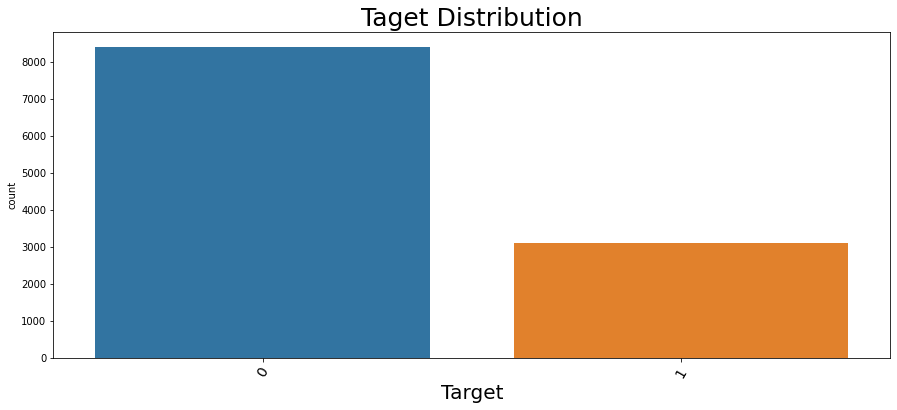

In [95]:
plt.figure(figsize=(15,6))
_=sns.countplot(train['target'],order=train['target'].value_counts().index)
_=plt.title("Taget Distribution",fontsize=25)
_=plt.xlabel('Target',fontsize=20)
_=plt.xticks(fontsize=14, rotation=60)

#### The above distribution shows that there is a class imbalance.

### Let's do a quick plot for all numerical column in the train dataset.

In [ ]:
for i,col in enumerate(train.iloc[:,np.r_[2,3,5:13]].columns.values):
  print(train[col])

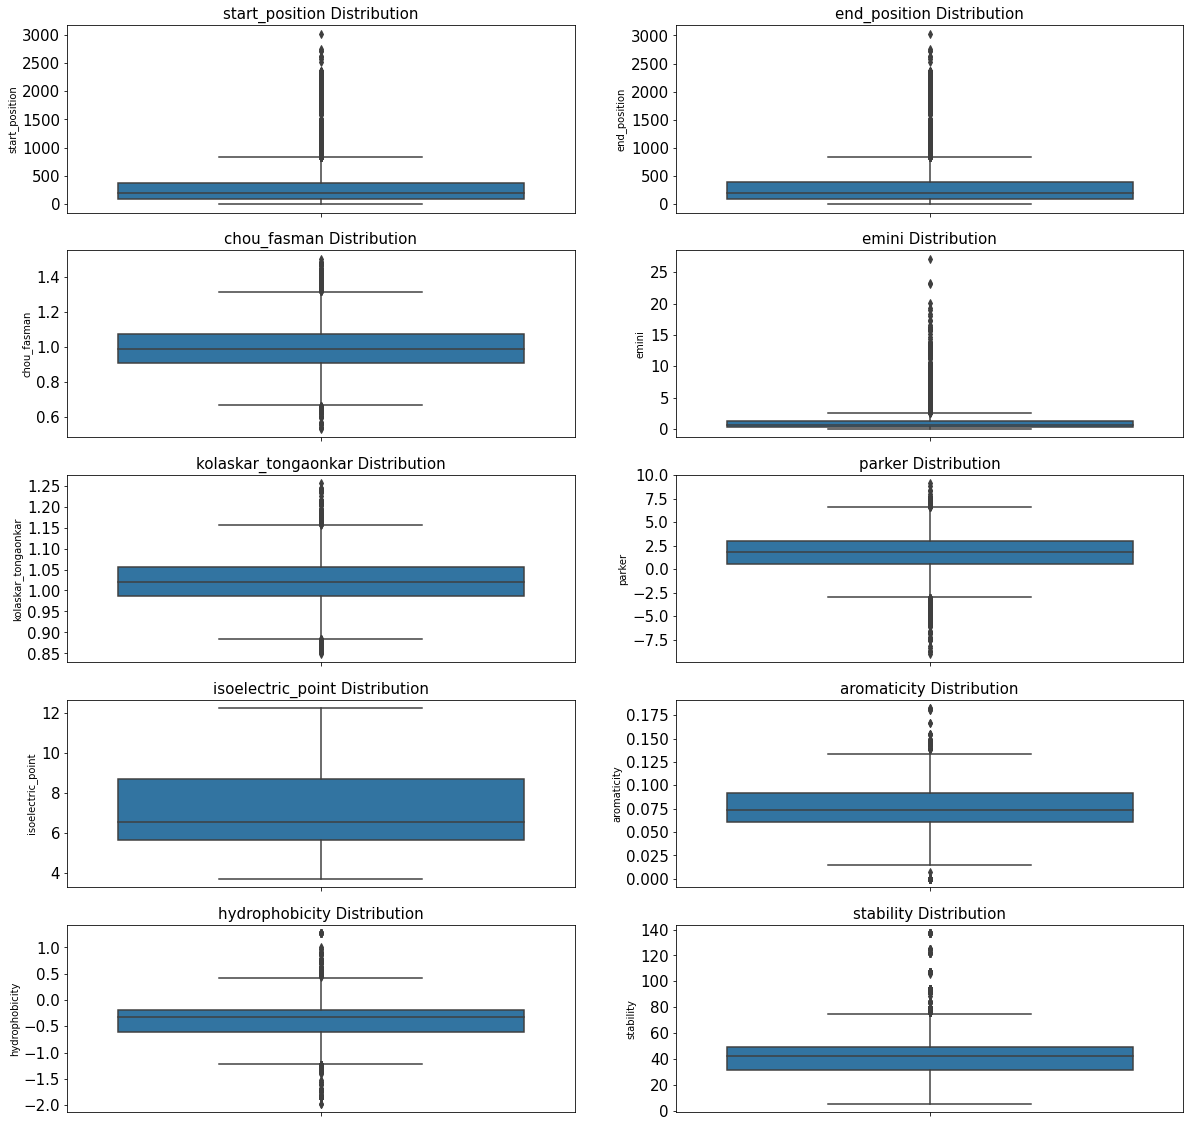

In [119]:
fig=plt.subplots(figsize=(20, 20))
for i,col in enumerate(train.iloc[:,np.r_[2,3,5:13]].columns.values):
  plt.subplot(5,2,i+1)
  _=sns.boxplot(y=train[col])
  _=plt.title(col+' Distribution',fontsize=15)
  _=plt.ylabel(col,fontsize=10)
  _=plt.yticks(fontsize=15)
 

  
plt.show()    

#### The above boxplot explains that there are outliers in all columns except the column isoelectric_point.

### Let's create a catboost classifier model with optuna hyperparemeter optimization.

In [ ]:
pip install optuna

In [ ]:
pip install catboost

### Import Necessary packages for model

In [8]:
from sklearn.model_selection import  cross_val_score,StratifiedKFold,train_test_split
from catboost import CatBoostClassifier,Pool,cv
import optuna
from optuna.samplers import RandomSampler
from sklearn.metrics import f1_score

### Create X(predictor) and y(target) column.

In [61]:
X=train.iloc[:,np.r_[1:13]]    
y=train['target']

### Create catboost classifier function

In [ ]:
def objective(trial):
  skf = StratifiedKFold(n_splits=10, random_state=5,shuffle=True)
  for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        'reg_lambda':trial.suggest_categorical('reg_lambda',[0.1, 1.0, 5.0, 10.0, 50.0, 100.0]),
        
        'learning_rate': trial.suggest_float('learning_rate', 0.001,1.0),
        'n_estimators': trial.suggest_categorical('n_estimators',[500]),
        'max_depth': trial.suggest_int('max_depth', 2,12),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
        "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",}
  if param["bootstrap_type"] == "Bayesian":
    param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
  elif param["bootstrap_type"] == "Bernoulli":
    param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

  cat_clf = CatBoostClassifier(early_stopping_rounds=100,loss_function='Logloss',
                               logging_level="Verbose",**param)
  cat_clf.fit(X_train, y_train,cat_features=['protein_seq','peptide_seq'])
  preds = cat_clf.predict(X_valid)
  accuracy = f1_score(y_valid, preds)
  return accuracy
  


if __name__ == "__main__":
    study = optuna.create_study(direction='maximize',sampler=RandomSampler(),
           pruner=optuna.pruners.MedianPruner( n_startup_trials=10,
                                              n_warmup_steps=30, interval_steps=10))
    study.optimize(objective, n_trials=50)
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)  

In [187]:
study.best_value

0.7085514834205934

### Visualizing the Optimization History - Explains the best score at each trails.

In [122]:
optuna.visualization.plot_optimization_history(study)

### Visualizing High-dimensional Parameter Relationships

In [123]:
optuna.visualization.plot_slice(study)

### Visualizing Parameter Importances

In [124]:
optuna.visualization.plot_param_importances(study)

### Get the best parameters from optuna study

In [73]:
updated_params=study.best_params

### Create a model with new parameters

In [74]:
model = CatBoostClassifier(**updated_params,early_stopping_rounds=10)

### Fit the model

In [ ]:
model.fit(X,y,cat_features=['protein_seq','peptide_seq'])

### Import shap for model explaination

In [ ]:
!pip install shap

In [ ]:
import shap
shap.initjs()

In [152]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X, y, cat_features=['protein_seq','peptide_seq']))

### Feature importance plot.

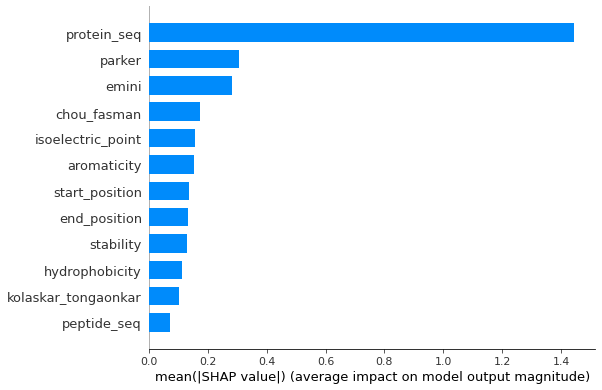

In [156]:
shap.summary_plot(shap_values, X, plot_type="bar")

### Top features impact the model

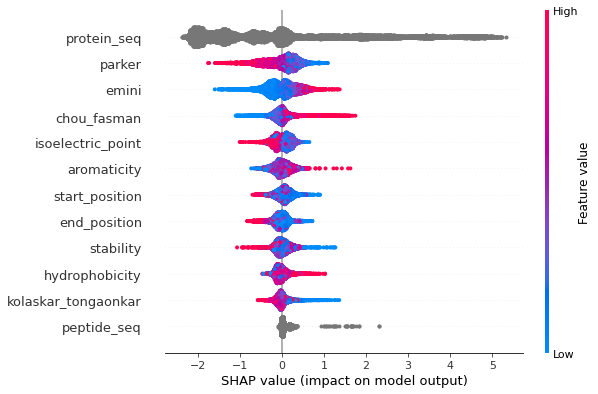

In [183]:
shap.summary_plot(shap_values,X)

### Let's see which feature influences the model prediction for a single observation. 

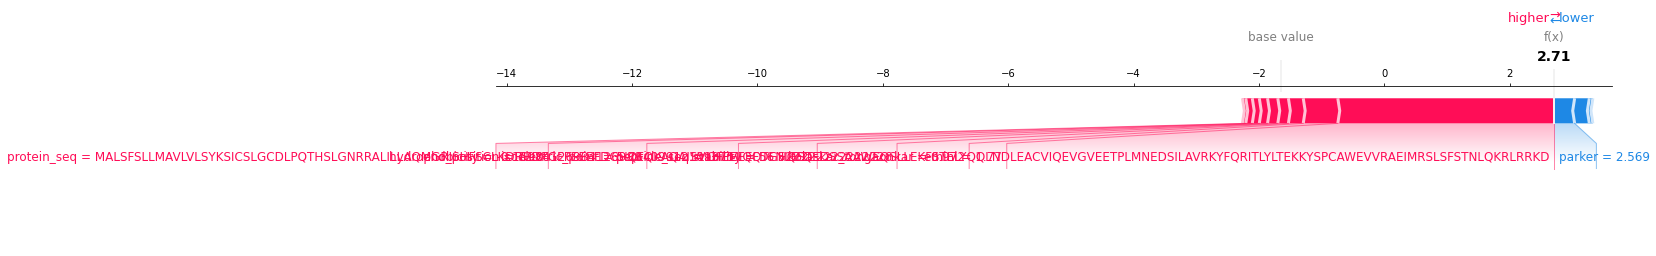

In [167]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:],matplotlib=True)

### Predict the test data

In [184]:
test['target']=model.predict(test.iloc[:,np.r_[1:13]])

### Create submission dataframe.

In [185]:
res=pd.DataFrame(test['target'])

### Write the dataframe as csv file

In [188]:
res.to_csv("catboost with optuna.csv",index=False)